# RestNet50 for SkinCancer diagnosis

### import all the libraries we need/ Importamos todas las librerias necesarias 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, InputLayer, Flatten, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from keras.applications.resnet import ResNet50, decode_predictions, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adadelta, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint

## Connect to my drive 

In [2]:
#First conect to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### ImageData generator using a preprocess function to the images. Selecting the batch_size and finally, making a data generator

In [3]:
def get_ImageDataGenerator():
  return ImageDataGenerator(
      preprocessing_function=preprocess_input,
      validation_split=0.1,
      horizontal_flip=True,
      vertical_flip=True,
      brightness_range=(0.8,1)
  )

batch = 32
def get_generator(image_data_generator,directory,seed=None,subset=None):
  return image_data_generator.flow_from_directory(
      directory,
      target_size=(224,224),
      batch_size=batch,
      class_mode='categorical',
      subset=subset,
      shuffle=True,
      seed=seed
  )

### now read the data from my drive and mak two datagenerators, for train an validation/test respectively

In [4]:
my_directory = '/content/drive/MyDrive/Proyectos/SkinCancer/data'

image_gen = get_ImageDataGenerator()
train_generator = get_generator(image_gen,my_directory,1,'training')
test_generator  = get_generator(image_gen,my_directory,1,'validation')

Found 9017 images belonging to 7 classes.
Found 998 images belonging to 7 classes.


### Showing some random data (with preprocess) 

Text(0.5, 1.0, 'Preprocessed Images')

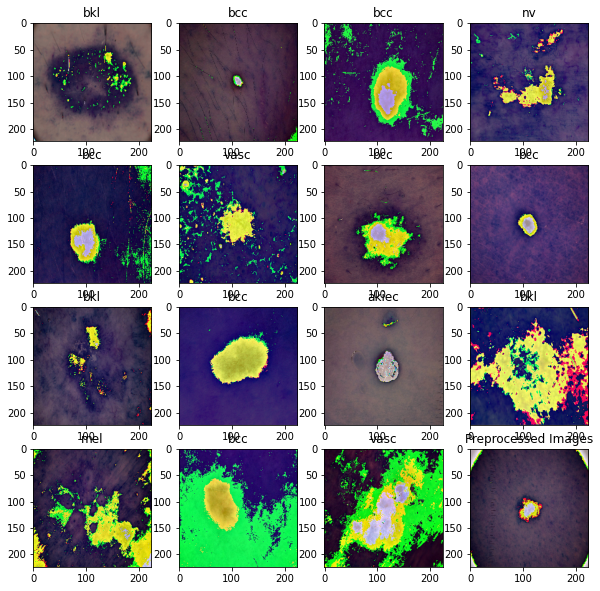

In [5]:
batch_prueba = next(train_generator)
#Now that i have a data generator, i'll print out some samples
classes = ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']

plt.figure(figsize=(10,10))
for n in range(16):
  ax = plt.subplot(4,4,n+1)
  plt.imshow(batch_prueba[0][n].astype('uint8'))
  plt.title(classes[np.where(batch_prueba[1][n]==1.)[0][0]])
  #plt.axis('off')
plt.title('Preprocessed Images')

### Defining our base model, in this case, i'm using RestNet as a feature extractor

In [6]:
#Pretained Model
def load_pretrained_model():
  input_t = Input(shape=(224,224,3))
  model = ResNet50(weights='imagenet',include_top=False,input_tensor=input_t)
  #Hacemos un freezing a las capas que ya estaban entrenadas en el modelo cargado
  model.trainable = False
  return model

In [7]:
base_model = load_pretrained_model()

In [ ]:
#base_model.summary()

### new function that will add a head over the base model we imported before

In [8]:
def add_new_head(feature_extractor_model):
  prev_output  = feature_extractor_model.output
  head_pooling = GlobalAveragePooling2D()(prev_output)
  head_drop1   = Dropout(0.25)(head_pooling)
  head_dense1  = Dense(128, activation='relu',kernel_regularizer=L2(2e-4),kernel_initializer='he_normal',bias_initializer='zeros')(head_drop1)
  head_drop2   = Dropout(0.5)(head_dense1)
  head_output  = Dense(7,activation='softmax')(head_drop2)
  model = Model(inputs=feature_extractor_model.input,outputs=head_output)

  opt = Adam(1e-3)
  model.compile(
      optimizer=opt,
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  return model

In [9]:
#new_model = add_new_head(feature_stractor)

new_model = add_new_head(base_model)

In [10]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

### Train the model, with some scheduler and a callback for early stopping when the metric does not change at all

In [11]:
def checkpoint_best():
  path = 'checkpoint_best/checkpoint'
  checkp = ModelCheckpoint(
      filepath=path,
      save_weights_only=True,
      save_freq='epoch',
      monitor='val_accuracy',
      save_best_only=True,
      verbose=1
  )
  return checkp

def checkpoint_finet_best():
  path = 'checkpoint_finet_best/ft_checkpoint'
  checkp = ModelCheckpoint(
      filepath=path,
      save_weights_only=True,
      save_freq='epoch',
      monitor='val_accuracy',
      save_best_only=True,
      verbose=1
  )
  return checkp

def scheduler(epoch,lr):
  if epoch<2:
    return lr
  else:
    return lr*tf.math.exp(-0.105)

def train_model_gen(model,train_gen,val_gen,epochs):
  early_stop = EarlyStopping(patience=2,monitor='val_accuracy')
  #reduce_lr  = ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,patience=2)
  
  return model.fit(
      train_gen,
      steps_per_epoch  = train_gen.samples // batch,
      validation_data  = val_gen,
      validation_steps = val_gen.samples // batch,
      epochs=epochs,
      callbacks=[tf.keras.callbacks.LearningRateScheduler(scheduler),early_stop,checkpoint_best()],
      verbose=1
      )

# Try-error section

In [ ]:
'''def add_new_head(feature_extractor_model):
  prev_output  = feature_extractor_model.output
  head_pooling = GlobalAveragePooling2D()(prev_output)
  head_drop1   = Dropout(0.25)(head_pooling)
  head_dense1  = Dense(128, activation='relu',kernel_regularizer=L2(1e-4),kernel_initializer='he_normal',bias_initializer='zeros')(head_drop1)
  head_drop2   = Dropout(0.5)(head_dense1)
  head_output  = Dense(7,activation='softmax')(head_drop2)
  model = Model(inputs=feature_extractor_model.input,outputs=head_output)

  opt = Adam(1e-3)
  model.compile(
      optimizer=opt,
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  return model'''
history = train_model_gen(new_model,train_generator,test_generator,20)

Epoch 1/20
250/250 [==============================] - 3399s 14s/step - loss: 0.9971 - accuracy: 0.6754 - val_loss: 0.7592 - val_accuracy: 0.7314 - lr: 0.0010
Epoch 2/20
250/250 [==============================] - 116s 464ms/step - loss: 0.8210 - accuracy: 0.7130 - val_loss: 0.7997 - val_accuracy: 0.7067 - lr: 0.0010
Epoch 3/20
250/250 [==============================] - 114s 455ms/step - loss: 0.7800 - accuracy: 0.7245 - val_loss: 0.6851 - val_accuracy: 0.7445 - lr: 9.0032e-04
Epoch 4/20
250/250 [==============================] - 114s 456ms/step - loss: 0.7426 - accuracy: 0.7329 - val_loss: 0.6423 - val_accuracy: 0.7641 - lr: 8.1058e-04
Epoch 5/20
250/250 [==============================] - 114s 454ms/step - loss: 0.7179 - accuracy: 0.7417 - val_loss: 0.6309 - val_accuracy: 0.7707 - lr: 7.2979e-04
Epoch 6/20
250/250 [==============================] - 114s 457ms/step - loss: 0.6891 - accuracy: 0.7539 - val_loss: 0.6276 - val_accuracy: 0.7671 - lr: 6.5705e-04
Epoch 7/20
250/250 [===========

In [ ]:
'''def add_new_head(feature_extractor_model):
  prev_output  = feature_extractor_model.output
  head_pooling = GlobalAveragePooling2D()(prev_output)
  head_drop1   = Dropout(0.25)(head_pooling)
  head_dense1  = Dense(256, activation='relu',kernel_regularizer=L2(1e-4),kernel_initializer='he_normal',bias_initializer='zeros')(head_drop1)
  head_drop2   = Dropout(0.5)(head_dense1)
  head_output  = Dense(7,activation='softmax')(head_drop2)
  model = Model(inputs=feature_extractor_model.input,outputs=head_output)

  opt = Adam(1e-3)
  model.compile(
      optimizer=opt,
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  return model'''
history2 = train_model_gen(new_model,train_generator,test_generator,5)

Epoch 1/5
250/250 [==============================] - 119s 464ms/step - loss: 1.0348 - accuracy: 0.6826 - val_loss: 0.7709 - val_accuracy: 0.7258 - lr: 0.0010
Epoch 2/5
250/250 [==============================] - 113s 452ms/step - loss: 0.8240 - accuracy: 0.7222 - val_loss: 0.6969 - val_accuracy: 0.7540 - lr: 0.0010
Epoch 3/5
250/250 [==============================] - 113s 452ms/step - loss: 0.7597 - accuracy: 0.7392 - val_loss: 0.6729 - val_accuracy: 0.7576 - lr: 9.0032e-04
Epoch 4/5
250/250 [==============================] - 113s 452ms/step - loss: 0.7252 - accuracy: 0.7534 - val_loss: 0.6446 - val_accuracy: 0.7712 - lr: 8.1058e-04
Epoch 5/5
250/250 [==============================] - 113s 453ms/step - loss: 0.6860 - accuracy: 0.7683 - val_loss: 0.6295 - val_accuracy: 0.7787 - lr: 7.2979e-04


In [ ]:
'''def add_new_head(feature_extractor_model):
  prev_output  = feature_extractor_model.output
  head_pooling = GlobalAveragePooling2D()(prev_output)
  head_drop1   = Dropout(0.25)(head_pooling)
  head_dense1  = Dense(512, activation='relu',kernel_regularizer=L2(1e-4),kernel_initializer='he_normal',bias_initializer='zeros')(head_drop1)
  head_drop2   = Dropout(0.5)(head_dense1)
  head_output  = Dense(7,activation='softmax')(head_drop2)
  model = Model(inputs=feature_extractor_model.input,outputs=head_output)

  opt = Adam(1e-3)
  model.compile(
      optimizer=opt,
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  return model'''
history3 = train_model_gen(new_model,train_generator,test_generator,5)

Epoch 1/5
250/250 [==============================] - 120s 469ms/step - loss: 1.1374 - accuracy: 0.6838 - val_loss: 0.7857 - val_accuracy: 0.7354 - lr: 0.0010
Epoch 2/5
250/250 [==============================] - 114s 456ms/step - loss: 0.8378 - accuracy: 0.7287 - val_loss: 0.7477 - val_accuracy: 0.7480 - lr: 0.0010
Epoch 3/5
250/250 [==============================] - 114s 458ms/step - loss: 0.7717 - accuracy: 0.7475 - val_loss: 0.6951 - val_accuracy: 0.7707 - lr: 9.0032e-04
Epoch 4/5
250/250 [==============================] - 113s 454ms/step - loss: 0.7194 - accuracy: 0.7659 - val_loss: 0.6784 - val_accuracy: 0.7732 - lr: 8.1058e-04
Epoch 5/5
250/250 [==============================] - 113s 453ms/step - loss: 0.6924 - accuracy: 0.7714 - val_loss: 0.6608 - val_accuracy: 0.7686 - lr: 7.2979e-04


In [ ]:
'''def add_new_head(feature_extractor_model):
  prev_output  = feature_extractor_model.output
  head_pooling = GlobalAveragePooling2D()(prev_output)
  head_drop1   = Dropout(0.25)(head_pooling)
  head_dense1  = Dense(512, activation='relu',kernel_regularizer=L2(1e-4),kernel_initializer='he_normal',bias_initializer='zeros')(head_drop1)
  head_drop2   = Dropout(0.5)(head_dense1)
  head_dense2  = Dense(256, activation='relu',kernel_regularizer=L2(1e-4),kernel_initializer='he_normal',bias_initializer='zeros')(head_drop2)
  head_drop3   = Dropout(0.5)(head_dense2)
  head_dense3  = Dense(128, activation='relu',kernel_regularizer=L2(1e-4),kernel_initializer='he_normal',bias_initializer='zeros')(head_drop3)
  head_drop4   = Dropout(0.5)(head_dense3)
  head_output  = Dense(7,activation='softmax')(head_drop4)
  model = Model(inputs=feature_extractor_model.input,outputs=head_output)

  opt = Adam(1e-3)
  model.compile(
      optimizer=opt,
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  return model'''
history4 = train_model_gen(new_model,train_generator,test_generator,5)

Epoch 1/5
250/250 [==============================] - 120s 467ms/step - loss: 1.5609 - accuracy: 0.6202 - val_loss: 1.1028 - val_accuracy: 0.6961 - lr: 0.0010
Epoch 2/5
250/250 [==============================] - 114s 454ms/step - loss: 1.1609 - accuracy: 0.6669 - val_loss: 1.0045 - val_accuracy: 0.6961 - lr: 0.0010
Epoch 3/5
250/250 [==============================] - 113s 451ms/step - loss: 1.0686 - accuracy: 0.6809 - val_loss: 0.9580 - val_accuracy: 0.7026 - lr: 9.0032e-04
Epoch 4/5
250/250 [==============================] - 113s 451ms/step - loss: 1.0284 - accuracy: 0.6917 - val_loss: 0.9168 - val_accuracy: 0.7198 - lr: 8.1058e-04
Epoch 5/5
250/250 [==============================] - 114s 455ms/step - loss: 0.9802 - accuracy: 0.7056 - val_loss: 0.8938 - val_accuracy: 0.7132 - lr: 7.2979e-04


In [ ]:
'''def add_new_head(feature_extractor_model):
  prev_output  = feature_extractor_model.output
  head_pooling = GlobalAveragePooling2D()(prev_output)
  head_drop1   = Dropout(0.25)(head_pooling)
  head_dense1  = Dense(128, activation='relu',kernel_regularizer=L2(1e-4),kernel_initializer='he_normal',bias_initializer='zeros')(head_drop1)
  head_drop2   = Dropout(0.5)(head_dense1)
  head_dense2  = Dense(128, activation='relu',kernel_regularizer=L2(1e-4),kernel_initializer='he_normal',bias_initializer='zeros')(head_drop2)
  head_drop3   = Dropout(0.5)(head_dense2)
  head_dense3  = Dense(128, activation='relu',kernel_regularizer=L2(1e-4),kernel_initializer='he_normal',bias_initializer='zeros')(head_drop3)
  head_drop4   = Dropout(0.5)(head_dense3)
  head_output  = Dense(7,activation='softmax')(head_drop4)
  model = Model(inputs=feature_extractor_model.input,outputs=head_output)

  opt = Adam(1e-3)
  model.compile(
      optimizer=opt,
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  return model'''
history5 = train_model_gen(new_model,train_generator,test_generator,5)

Epoch 1/5
250/250 [==============================] - 119s 462ms/step - loss: 1.4256 - accuracy: 0.6198 - val_loss: 0.9958 - val_accuracy: 0.6699 - lr: 0.0010
Epoch 2/5
250/250 [==============================] - 114s 457ms/step - loss: 1.0938 - accuracy: 0.6664 - val_loss: 0.9248 - val_accuracy: 0.6719 - lr: 0.0010
Epoch 3/5
250/250 [==============================] - 114s 455ms/step - loss: 1.0440 - accuracy: 0.6679 - val_loss: 0.9275 - val_accuracy: 0.6704 - lr: 9.0032e-04
Epoch 4/5
250/250 [==============================] - 114s 455ms/step - loss: 1.0155 - accuracy: 0.6687 - val_loss: 0.8975 - val_accuracy: 0.6714 - lr: 8.1058e-04
Epoch 5/5
250/250 [==============================] - 113s 453ms/step - loss: 0.9927 - accuracy: 0.6684 - val_loss: 0.9103 - val_accuracy: 0.6689 - lr: 7.2979e-04


In [ ]:
'''def add_new_head(feature_extractor_model):
  prev_output  = feature_extractor_model.output
  head_pooling = GlobalAveragePooling2D()(prev_output)
  head_drop1   = Dropout(0.25)(head_pooling)
  head_dense1  = Dense(128, activation='relu',kernel_regularizer=L2(1e-5),kernel_initializer='he_normal',bias_initializer='zeros')(head_drop1)
  head_drop2   = Dropout(0.5)(head_dense1)
  head_dense2  = Dense(128, activation='relu',kernel_regularizer=L2(1e-5),kernel_initializer='he_normal',bias_initializer='zeros')(head_drop2)
  head_drop3   = Dropout(0.5)(head_dense2)
  head_dense3  = Dense(128, activation='relu',kernel_regularizer=L2(1e-5),kernel_initializer='he_normal',bias_initializer='zeros')(head_drop3)
  head_drop4   = Dropout(0.5)(head_dense3)
  head_output  = Dense(7,activation='softmax')(head_drop4)
  model = Model(inputs=feature_extractor_model.input,outputs=head_output)

  opt = Adam(1e-4)
  model.compile(
      optimizer=opt,
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  return model'''
history6 = train_model_gen(new_model,train_generator,test_generator,5)

Epoch 1/5
250/250 [==============================] - 119s 464ms/step - loss: 2.2031 - accuracy: 0.4577 - val_loss: 1.1654 - val_accuracy: 0.6704 - lr: 1.0000e-04
Epoch 2/5
250/250 [==============================] - 115s 458ms/step - loss: 1.2942 - accuracy: 0.6087 - val_loss: 1.0422 - val_accuracy: 0.6709 - lr: 1.0000e-04
Epoch 3/5
250/250 [==============================] - 114s 457ms/step - loss: 1.1807 - accuracy: 0.6429 - val_loss: 0.9652 - val_accuracy: 0.6689 - lr: 9.0032e-05
Epoch 4/5
250/250 [==============================] - 115s 462ms/step - loss: 1.1087 - accuracy: 0.6535 - val_loss: 0.9436 - val_accuracy: 0.6709 - lr: 8.1058e-05
Epoch 5/5
250/250 [==============================] - 115s 460ms/step - loss: 1.0715 - accuracy: 0.6592 - val_loss: 0.9511 - val_accuracy: 0.6683 - lr: 7.2979e-05


In [ ]:
'''def add_new_head(feature_extractor_model):
  prev_output  = feature_extractor_model.output
  head_pooling = GlobalAveragePooling2D()(prev_output)
  head_drop1   = Dropout(0.25)(head_pooling)
  head_dense1  = Dense(256, activation='relu',kernel_regularizer=L2(1e-4),kernel_initializer='he_normal',bias_initializer='ones')(head_drop1)
  head_drop2   = Dropout(0.5)(head_dense1)
  head_output  = Dense(7,activation='softmax')(head_drop2)
  model = Model(inputs=feature_extractor_model.input,outputs=head_output)

  opt = Adam(1e-3)
  model.compile(
      optimizer=opt,
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  return model'''
history7 = train_model_gen(new_model,train_generator,test_generator,5)

Epoch 1/5
250/250 [==============================] - 120s 469ms/step - loss: 1.1683 - accuracy: 0.6791 - val_loss: 0.7619 - val_accuracy: 0.7409 - lr: 0.0010
Epoch 2/5
250/250 [==============================] - 114s 457ms/step - loss: 0.8232 - accuracy: 0.7233 - val_loss: 0.7027 - val_accuracy: 0.7540 - lr: 0.0010
Epoch 3/5
250/250 [==============================] - 114s 455ms/step - loss: 0.7623 - accuracy: 0.7389 - val_loss: 0.6599 - val_accuracy: 0.7631 - lr: 9.0032e-04
Epoch 4/5
250/250 [==============================] - 114s 456ms/step - loss: 0.7291 - accuracy: 0.7427 - val_loss: 0.6494 - val_accuracy: 0.7686 - lr: 8.1058e-04
Epoch 5/5
250/250 [==============================] - 114s 456ms/step - loss: 0.7085 - accuracy: 0.7582 - val_loss: 0.6313 - val_accuracy: 0.7727 - lr: 7.2979e-04


Text(0.5, 1.0, 'val_loss')

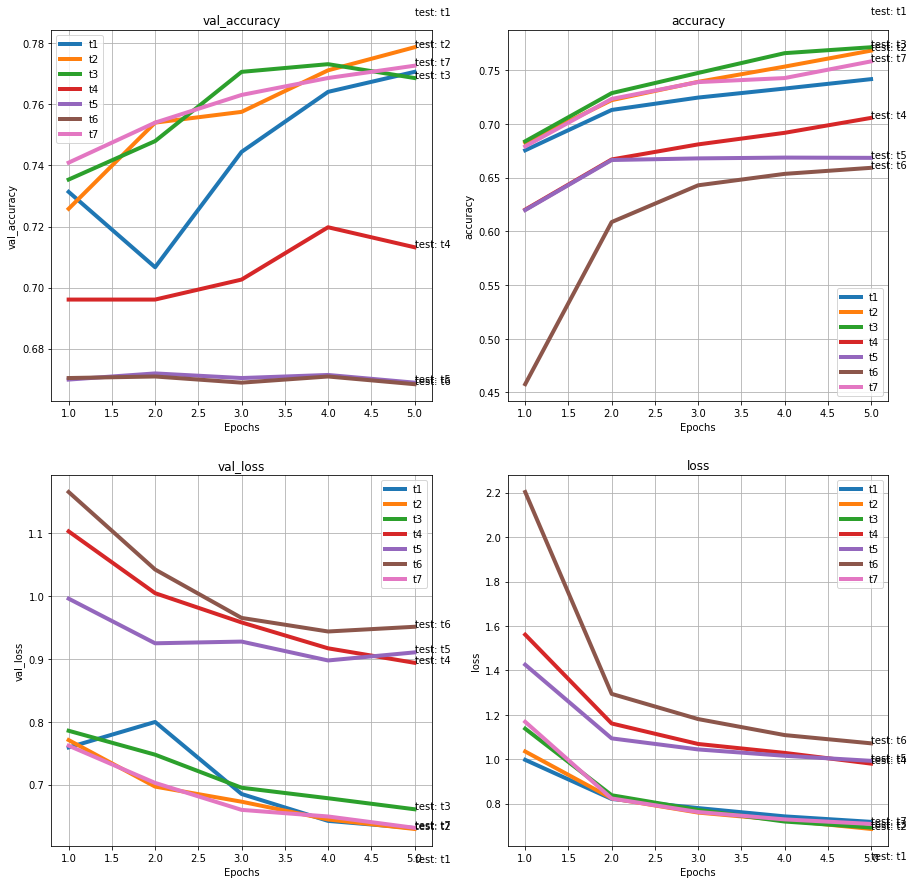

In [ ]:
history_data = {
    't1': history.history,
    't2': history2.history,
    't3': history3.history,
    't4': history4.history,
    't5': history5.history,
    't6': history6.history,
    't7': history7.history,
}
from IPython.core.pylabtools import figsize
epochs = [1,2,3,4,5]

fig, axs = plt.subplots(2,2,figsize=(15,15))
#-----------
subplot1 = 'val_accuracy'
for k, h in history_data.items():
  axs[0,0].plot(epochs,h[subplot1][:5],label=k,linewidth=4.0)
  axs[0,0].text(epochs[-1],h[subplot1][-1],f'test: {k}')
axs[0,0].set_ylabel(subplot1)
axs[0,0].set_xlabel('Epochs')
axs[0,0].grid(True)
axs[0,0].legend()
axs[0,0].set_title(subplot1)

#-----------
subplot1 = 'accuracy'
for k, h in history_data.items():
  axs[0,1].plot(epochs,h[subplot1][:5],label=k,linewidth=4.0)
  axs[0,1].text(epochs[-1],h[subplot1][-1],f'test: {k}')
axs[0,1].set_ylabel(subplot1)
axs[0,1].set_xlabel('Epochs')
axs[0,1].grid(True)
axs[0,1].legend()
axs[0,1].set_title(subplot1)

#-----------
subplot1 = 'loss'
for k, h in history_data.items():
  axs[1,1].plot(epochs,h[subplot1][:5],label=k,linewidth=4.0)
  axs[1,1].text(epochs[-1],h[subplot1][-1],f'test: {k}')
axs[1,1].set_ylabel(subplot1)
axs[1,1].set_xlabel('Epochs')
axs[1,1].grid(True)
axs[1,1].legend()
axs[1,1].set_title(subplot1)

#-----------
subplot1 = 'val_loss'
for k, h in history_data.items():
  axs[1,0].plot(epochs,h[subplot1][:5],label=k,linewidth=4.0)
  axs[1,0].text(epochs[-1],h[subplot1][-1],f'test: {k}')
axs[1,0].set_ylabel(subplot1)
axs[1,0].set_xlabel('Epochs')
axs[1,0].grid(True)
axs[1,0].legend()
axs[1,0].set_title(subplot1)

In [ ]:
history_f = train_model_gen(new_model,train_generator,test_generator,20)

Epoch 1/20
250/250 [==============================] - 120s 470ms/step - loss: 1.1123 - accuracy: 0.6778 - val_loss: 0.7550 - val_accuracy: 0.7293 - lr: 0.0010
Epoch 2/20
250/250 [==============================] - 115s 459ms/step - loss: 0.8289 - accuracy: 0.7235 - val_loss: 0.6964 - val_accuracy: 0.7525 - lr: 0.0010
Epoch 3/20
250/250 [==============================] - 114s 458ms/step - loss: 0.7527 - accuracy: 0.7448 - val_loss: 0.6615 - val_accuracy: 0.7661 - lr: 9.0032e-04
Epoch 4/20
250/250 [==============================] - 115s 459ms/step - loss: 0.7189 - accuracy: 0.7545 - val_loss: 0.6375 - val_accuracy: 0.7782 - lr: 8.1058e-04
Epoch 5/20
250/250 [==============================] - 116s 465ms/step - loss: 0.6864 - accuracy: 0.7655 - val_loss: 0.6302 - val_accuracy: 0.7757 - lr: 7.2979e-04
Epoch 6/20
250/250 [==============================] - 115s 462ms/step - loss: 0.6611 - accuracy: 0.7720 - val_loss: 0.6267 - val_accuracy: 0.7777 - lr: 6.5705e-04
Epoch 7/20
250/250 [==========

In [ ]:
#head_drop1   = Dropout(0.3)(head_pooling)
#head_dense1  = Dense(256, activation='relu',kernel_regularizer=L2(1e-6),kernel_initializer='he_normal',bias_initializer='ones')(head_drop1)
history_f2 = train_model_gen(new_model,train_generator,test_generator,20)

Epoch 1/20
250/250 [==============================] - 118s 463ms/step - loss: 1.0514 - accuracy: 0.6819 - val_loss: 0.6730 - val_accuracy: 0.7525 - lr: 0.0010
Epoch 2/20
250/250 [==============================] - 115s 460ms/step - loss: 0.7748 - accuracy: 0.7217 - val_loss: 0.6515 - val_accuracy: 0.7460 - lr: 0.0010
Epoch 3/20
250/250 [==============================] - 114s 454ms/step - loss: 0.7231 - accuracy: 0.7376 - val_loss: 0.6304 - val_accuracy: 0.7606 - lr: 9.0032e-04
Epoch 4/20
250/250 [==============================] - 114s 456ms/step - loss: 0.6704 - accuracy: 0.7547 - val_loss: 0.6076 - val_accuracy: 0.7651 - lr: 8.1058e-04
Epoch 5/20
250/250 [==============================] - 114s 456ms/step - loss: 0.6625 - accuracy: 0.7596 - val_loss: 0.5966 - val_accuracy: 0.7747 - lr: 7.2979e-04
Epoch 6/20
250/250 [==============================] - 114s 455ms/step - loss: 0.6308 - accuracy: 0.7686 - val_loss: 0.5834 - val_accuracy: 0.7787 - lr: 6.5705e-04
Epoch 7/20
250/250 [==========

In [ ]:
#head_drop1   = Dropout(0.3)(head_pooling)
#head_dense1  = Dense(256, activation='relu',kernel_regularizer=L2(1e-5),kernel_initializer='he_normal',bias_initializer='zeros')(head_drop1)
history_f3 = train_model_gen(new_model,train_generator,test_generator,20)

Epoch 1/20
250/250 [==============================] - 119s 464ms/step - loss: 1.0073 - accuracy: 0.6767 - val_loss: 0.7092 - val_accuracy: 0.7374 - lr: 0.0010
Epoch 2/20
250/250 [==============================] - 114s 458ms/step - loss: 0.7897 - accuracy: 0.7185 - val_loss: 0.6642 - val_accuracy: 0.7505 - lr: 0.0010
Epoch 3/20
250/250 [==============================] - 114s 454ms/step - loss: 0.7358 - accuracy: 0.7346 - val_loss: 0.6479 - val_accuracy: 0.7510 - lr: 9.0032e-04
Epoch 4/20
250/250 [==============================] - 114s 456ms/step - loss: 0.6849 - accuracy: 0.7495 - val_loss: 0.6353 - val_accuracy: 0.7591 - lr: 8.1058e-04
Epoch 5/20
250/250 [==============================] - 114s 455ms/step - loss: 0.6678 - accuracy: 0.7541 - val_loss: 0.6013 - val_accuracy: 0.7717 - lr: 7.2979e-04
Epoch 6/20
250/250 [==============================] - 114s 457ms/step - loss: 0.6445 - accuracy: 0.7641 - val_loss: 0.5838 - val_accuracy: 0.7717 - lr: 6.5705e-04
Epoch 7/20
250/250 [==========

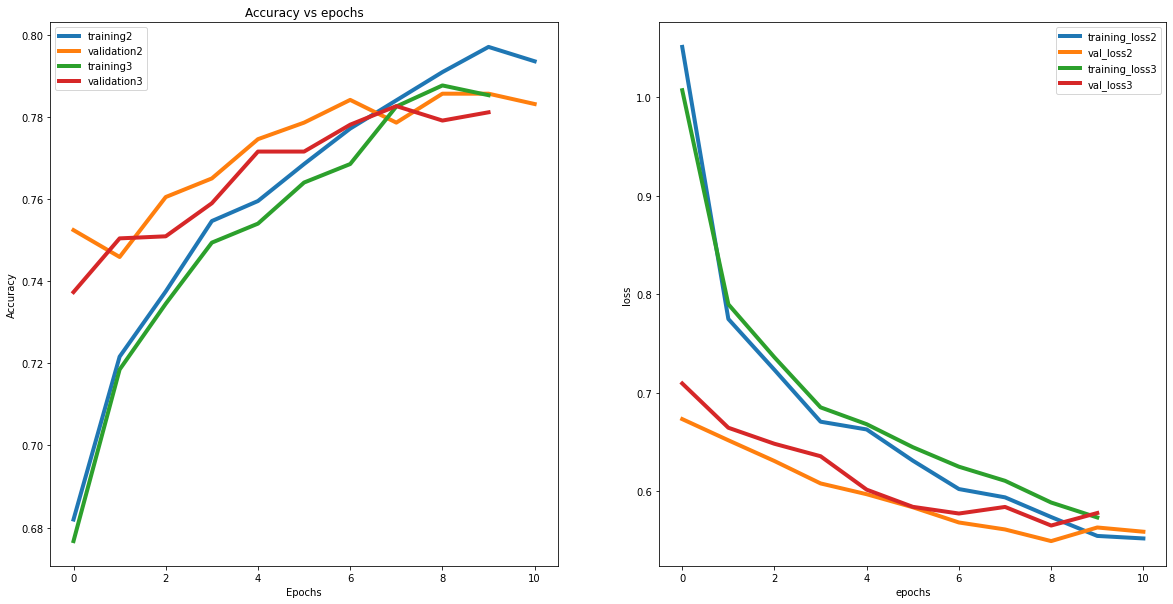

In [ ]:
history_data2 = {
    't1': history_f.history,
    't2': history_f2.history,
}
plt.figure(figsize=(20,10))
plt.subplot(121)

#plt.plot(history_f.history['accuracy'],linewidth=4.0)
#plt.plot(history_f.history['val_accuracy'],linewidth=4.0)
plt.plot(history_f2.history['accuracy'],linewidth=4.0)
plt.plot(history_f2.history['val_accuracy'],linewidth=4.0)
plt.plot(history_f3.history['accuracy'],linewidth=4.0)
plt.plot(history_f3.history['val_accuracy'],linewidth=4.0)
plt.title('Accuracy vs epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training2', 'validation2','training3', 'validation3'])
plt.subplot(122)
#plt.plot(history_f.history['loss'],linewidth=4.0)
#plt.plot(history_f.history['val_loss'],linewidth=4.0)
plt.plot(history_f2.history['loss'],linewidth=4.0)
plt.plot(history_f2.history['val_loss'],linewidth=4.0)
plt.plot(history_f3.history['loss'],linewidth=4.0)
plt.plot(history_f3.history['val_loss'],linewidth=4.0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['training_loss2','val_loss2','training_loss3','val_loss3'])
plt.show()

# New Section

In [12]:
history = train_model_gen(new_model,train_generator,test_generator,20)

Epoch 1/20
281/281 [==============================] - ETA: 0s - loss: 1.0587 - accuracy: 0.6660
Epoch 1: val_accuracy improved from -inf to 0.69052, saving model to checkpoint_best/checkpoint
281/281 [==============================] - 175s 579ms/step - loss: 1.0587 - accuracy: 0.6660 - val_loss: 0.7963 - val_accuracy: 0.6905 - lr: 0.0010
Epoch 2/20
281/281 [==============================] - ETA: 0s - loss: 0.8695 - accuracy: 0.6987
Epoch 2: val_accuracy improved from 0.69052 to 0.71875, saving model to checkpoint_best/checkpoint
281/281 [==============================] - 166s 592ms/step - loss: 0.8695 - accuracy: 0.6987 - val_loss: 0.7412 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 3/20
281/281 [==============================] - ETA: 0s - loss: 0.8226 - accuracy: 0.7134
Epoch 3: val_accuracy improved from 0.71875 to 0.76008, saving model to checkpoint_best/checkpoint
281/281 [==============================] - 164s 585ms/step - loss: 0.8226 - accuracy: 0.7134 - val_loss: 0.6859 - val_accu

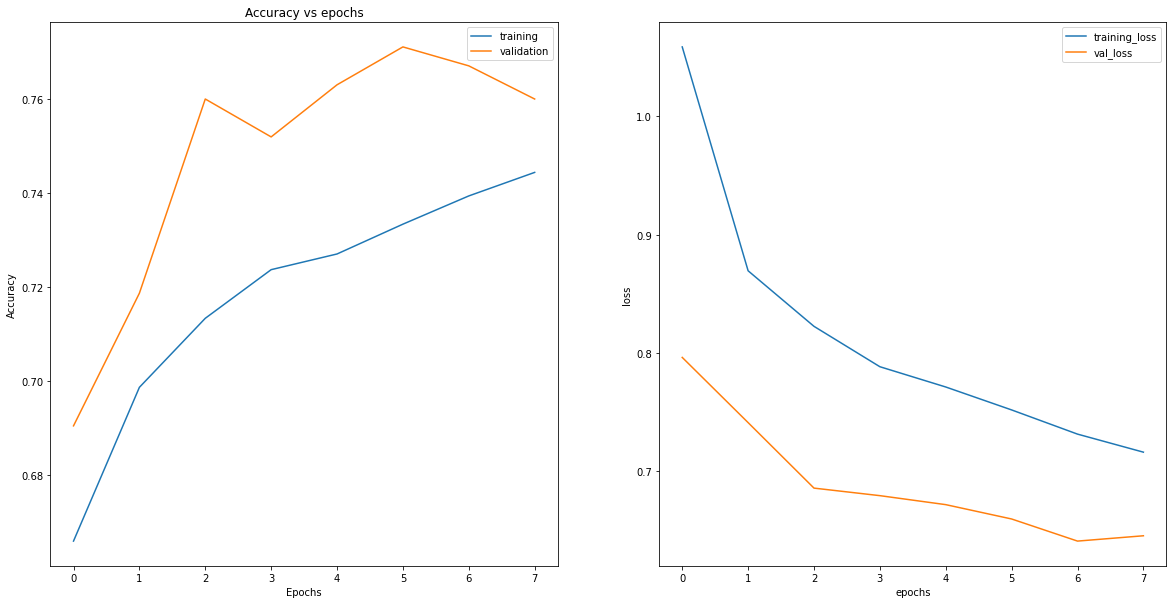

In [13]:
plt.figure(figsize=(20,10))
plt.subplot(121)
try:
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
except KeyError:
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
plt.title('Accuracy vs epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'])
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['training_loss','val_loss'])
plt.show()

# Fine tunning

In [14]:
base_model = load_pretrained_model()
new_model = add_new_head(base_model)

new_model.load_weights('/content/checkpoint_best/checkpoint')

In [15]:
print("Number of layers: ", len(base_model.layers))

Number of layers:  175


In [16]:
base_model.trainable =True
fine_tune_at = 125
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [17]:
early_stop = EarlyStopping(patience=2,monitor='val_accuracy')

new_model.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    optimizer = Adam(1e-5)
)
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [18]:
ini_epochs = len(history.epoch)
fine_tun_epochs = 20
total_epochs = ini_epochs + fine_tun_epochs
def train_model_fine_tuning(model,train_gen,val_gen,total_epochs,ini_epoch):
  early_stop = EarlyStopping(patience=2,monitor='val_accuracy')
  #reduce_lr  = ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,patience=2)
  
  return model.fit(
      train_gen,
      steps_per_epoch  = train_gen.samples // batch,
      validation_data  = val_gen,
      validation_steps = val_gen.samples // batch,
      epochs=total_epochs,
      initial_epoch=ini_epoch,
      callbacks=[tf.keras.callbacks.LearningRateScheduler(scheduler),early_stop,checkpoint_finet_best()],
      verbose=1
      )

In [19]:
fine_history = train_model_fine_tuning(new_model,train_generator,test_generator,total_epochs,ini_epochs)

Epoch 9/28
281/281 [==============================] - ETA: 0s - loss: 0.8123 - accuracy: 0.7145
Epoch 9: val_accuracy improved from -inf to 0.78831, saving model to checkpoint_finet_best/ft_checkpoint
281/281 [==============================] - 174s 601ms/step - loss: 0.8123 - accuracy: 0.7145 - val_loss: 0.6345 - val_accuracy: 0.7883 - lr: 9.0032e-06
Epoch 10/28
281/281 [==============================] - ETA: 0s - loss: 0.6966 - accuracy: 0.7579
Epoch 10: val_accuracy improved from 0.78831 to 0.79738, saving model to checkpoint_finet_best/ft_checkpoint
281/281 [==============================] - 165s 587ms/step - loss: 0.6966 - accuracy: 0.7579 - val_loss: 0.5775 - val_accuracy: 0.7974 - lr: 8.1058e-06
Epoch 11/28
281/281 [==============================] - ETA: 0s - loss: 0.6496 - accuracy: 0.7696
Epoch 11: val_accuracy did not improve from 0.79738
281/281 [==============================] - 164s 583ms/step - loss: 0.6496 - accuracy: 0.7696 - val_loss: 0.5700 - val_accuracy: 0.7923 - lr:

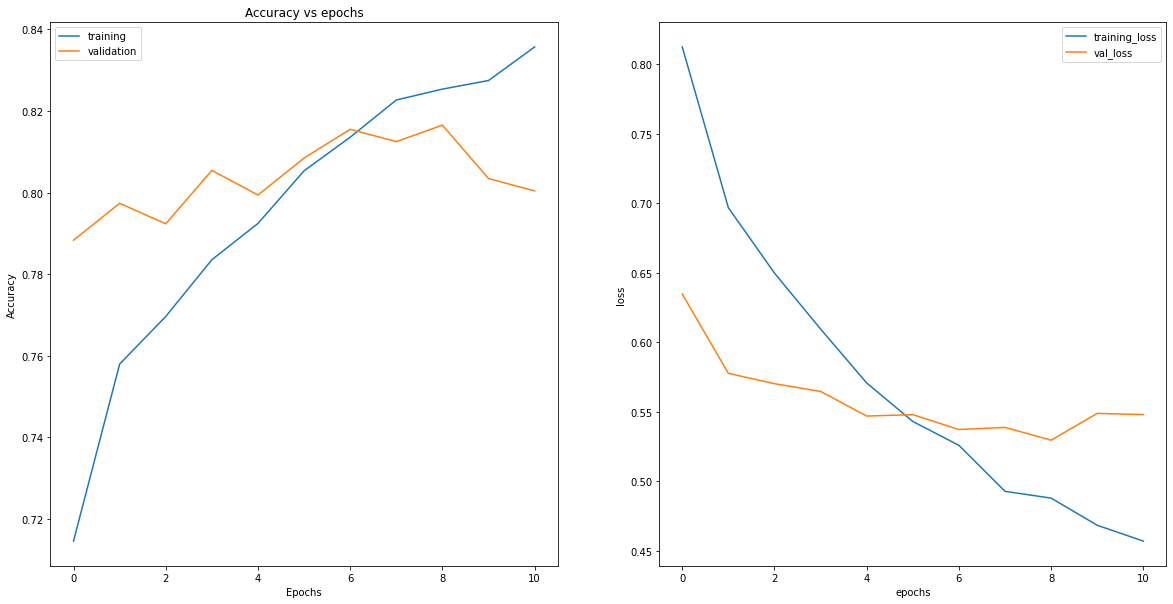

In [21]:
plt.figure(figsize=(20,10))
plt.subplot(121)
try:
  plt.plot(fine_history.history['accuracy'])
  plt.plot(fine_history.history['val_accuracy'])
except KeyError:
  plt.plot(fine_history.history['acc'])
  plt.plot(fine_history.history['val_acc'])
plt.title('Accuracy vs epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'])
plt.subplot(122)
plt.plot(fine_history.history['loss'])
plt.plot(fine_history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['training_loss','val_loss'])
plt.show()